In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline

# Some additional libraries which we'll use just
# to produce some visualizations of our training
from libs.utils import montage
from libs import gif
import IPython.display as ipyd
plt.style.use('ggplot')

# Bit of formatting because I don't like the default inline code style:
from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

## Use Autoencoders   -- unsurprised

- An autoencoder is a type of neural network that learns to encode its inputs, often using much less data. It does so in a way that it can still output the original input with just the encoded values. For it to learn, it does not require "labels" as its output. Instead, it tries to output whatever it was given as input. So in goes an image, and out should also go the same image. But it has to be able to retain all the details of the image, even after possibly reducing the information down to just a few numbers.
- We'll also explore how this method can be extended and used to cluster or organize a dataset, or to explore latent dimensions of a dataset that explain some interesting ideas. For instance, we'll see how with handwritten numbers, we will be able to see how each number can be encoded in the autoencoder without ever telling it which number is which.

#### Read mnist data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist= input_data.read_data_sets('../data/mnist/',one_hot=True)

Extracting ../data/mnist/train-images-idx3-ubyte.gz
Extracting ../data/mnist/train-labels-idx1-ubyte.gz
Extracting ../data/mnist/t10k-images-idx3-ubyte.gz
Extracting ../data/mnist/t10k-labels-idx1-ubyte.gz


Label:  [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


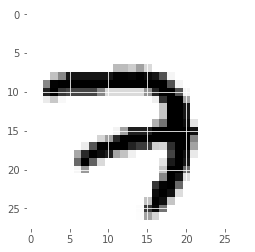

In [3]:
## take a look at the first image
i = mnist.train.images[0].reshape(28,28)
plt.imshow(i,cmap='Greys')
print('Label: ',mnist.train.labels[0])

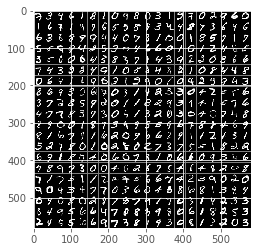

In [4]:
## take a look at firt 1000 images
imgs = mnist.train.images[:400].reshape(-1,28,28)  ## unflaten 2d to 3d
plt.imshow(montage(imgs),cmap='gray')              ## montage function is defined
                                                   ## in utility 

#### Take a look at mean and standard deviation

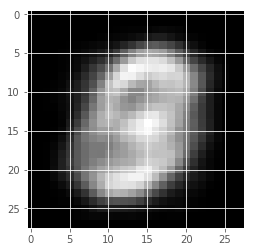

In [5]:
# Take the mean across all images
mean_img = np.mean(imgs, axis=0)
plt.imshow(mean_img, cmap='gray')

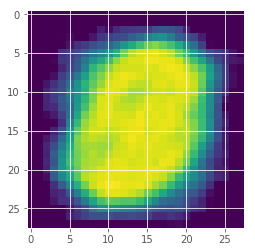

In [6]:
# Take the mean across all images
std_img = np.std(imgs, axis=0)
plt.imshow(std_img)

##### Now we can see, actually only the central part of the image chages, pixels on the edges does not really matter

####  We will started with fully connected model 

To try and encode our dataset, we are going to build a series of fully connected layers that get progressively smaller. So in neural net speak, every pixel is going to become its own input neuron. And from the original 784 neurons, we're going to slowly reduce that information down to smaller and smaller numbers. It's often standard practice to use other powers of 2 or 10. I'll create a list of the number of dimensions we'll use for each new layer.

<img src='pic/autoencoder_0.png',height=400, width = 900>

In [7]:
dimensions = [512, 256, 128, 64]             # reduce the feature thourgh each layer
n_features = mnist.train.images.shape[1]     # training set is a matrix, each row is a picture, with 784 pixels 
X = tf.placeholder(tf.float32, [None, n_features])  # first dimention is none, to make it flexible

In [8]:
##building the encoding network ###
##################################
current_input = X
n_input = n_features
Ws = []           # We're going to keep every matrix we create so let's create a list to hold them all

# We'll create a for loop to create each layer, this is the same as we did in previous session:
for layer_i, n_output in enumerate(dimensions):
    with tf.variable_scope("encoder/layer/{}".format(layer_i)): ## put each layer in scopes
        W = tf.get_variable(
            name='W',
            shape=[n_input, n_output],
            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))
        h = tf.matmul(current_input, W)
        current_input = tf.nn.relu(h)
        Ws.append(W)    # Finally we'll store the weight matrix so we can build the decoder.
        n_input = n_output  ## change the dimension, make n_input to be n_output for next iteration

In [9]:
##building the decoding network ###
##################################

Ws = Ws[::-1]      # We'll first reverse the order of our weight matrices
dimensions = dimensions[::-1][1:] + [n_features] # then reverse the order of our dimensions
print(dimensions)                                   # appending the last layers number of inputs.

for layer_i, n_output in enumerate(dimensions):
    with tf.variable_scope("decoder/layer/{}".format(layer_i)):
        W = tf.transpose(Ws[layer_i])
        h = tf.matmul(current_input, W)
        current_input = tf.nn.relu(h)
        n_input = n_output

[128, 256, 512, 784]


In [10]:
## after going through encoding and decoding process, assign Y as current_input -- wich is the end result 
Y= current_input

# We'll first measure the average difference across every pixel
cost = tf.reduce_mean(tf.squared_difference(X, Y), 1)   ## remember X and Y are 2d matrix, rows are images, 
                                                        ## we take the squared difference of images 
cost = tf.reduce_mean(cost)                             ## then average accross all images 
print(cost.get_shape())                                 ## it should end up with an scaler 

()


#### Run training process 

In [11]:
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Some parameters for training
batch_size = 100
n_batch = mnist.train.num_examples//batch_size     ## get the integer number 
n_epochs = 5

examples = mnist.train.images[:100]
mean_img=mean_img.flatten()

0 0.053097
1 0.0418191
2 0.0391243
3 0.0371505
4 0.035858


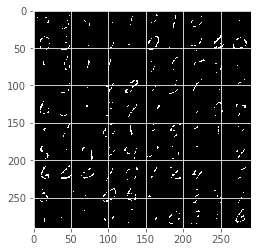

In [12]:
# We'll store the reconstructions in a list
imgs = []
fig, ax = plt.subplots(1, 1)

for epoch_i in range(n_epochs):
    for i in range(n_batch):
        batch_X, _ = mnist.train.next_batch(batch_size)                        ## next_batch(n) returns X and Y 
        sess.run(optimizer, feed_dict={X: batch_X - mean_img})                 ## 
    recon = sess.run(Y, feed_dict={X: examples - mean_img})                    ## So what does this mean ???????
    recon = np.clip((recon + mean_img).reshape((-1, 28, 28)), 0, 255)
    img_i = montage(recon).astype(np.uint8)
    imgs.append(img_i)
    ax.imshow(img_i, cmap='gray')
    fig.canvas.draw()
    print(epoch_i, sess.run(cost, feed_dict={X: mnist.train.images - mean_img}))
#gif.build_gif(imgs, saveto='ae.gif', cmap='gray')                            ## need to install ffmpeg 

### Convolutional autoencoder 

In [8]:
## reset the default graph 
from tensorflow.python.framework import ops
ops.reset_default_graph()
g=tf.get_default_graph()
[op.name for op in g.get_operations()]

[]

- we will construct 3 layers and use 16 filters with 4 pixels  
- we will use 2X2 stride, so after applying each filter,picture size get shink to half
<img src="pic/Convolution_encoding.PNG", height = 80%>

In [9]:
mean_img=mean_img.flatten()                 ## flatten mean image, we reshaped it before
n_features = mnist.train.images.shape[1]  
X = tf.placeholder(tf.float32, [None, n_features])
X_tensor = tf.reshape(X, [-1, 28, 28, 1])   ## to use a Convolutional kernel, we need a 4d tensor, 
                                            ## here we will transform 2d input to 4d tensor, 
                                            ## -1 mean the first dimension is an constant, to be the 
                                            ## same as original input first dimension 

In [10]:
## we will have 3 layers and each have 16 filters, filter size is 4 pixels 
n_filters = [16, 16, 16]
filter_sizes = [4, 4, 4]

current_input = X_tensor   ## set current input as the first input tensor 
n_input = 1   ## instead of having 784 as our input features, we're going to have just 1
              ## as the picture is in grey scale, there is only 1 color chanel 
Ws = []       # We're going to keep every matrix we create so let's create a list to hold them all
shapes = []

for layer_i, n_output in enumerate(n_filters):
    with tf.variable_scope("encoder/layer/{}".format(layer_i)):
        shapes.append(current_input.get_shape().as_list())
        W = tf.get_variable(             ## initialize a random 4,4,1,16 convolution weigth matrix 
            name='W',
            shape=[
                filter_sizes[layer_i],
                filter_sizes[layer_i],
                n_input,
                n_output],
            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))
        h = tf.nn.conv2d(current_input, W,       ## apply the convolution filter
            strides=[1, 2, 2, 1], padding='SAME')## strides is 2 x 2, this will shink the image
        current_input = tf.nn.relu(h)
        Ws.append(W)
        n_input = n_output


Now with our convolutional encoder built and the encoding weights stored, we'll reverse the whole process to decode everything back out to the original image.

In [11]:
## reverse weights and shape
Ws.reverse()
shapes.reverse()
n_filters.reverse()
n_filters = n_filters[1:] + [1]        ## because it is a grey scale, the chanel will be 1
print(n_filters, filter_sizes, shapes) 

[16, 16, 1] [4, 4, 4] [[None, 7, 7, 16], [None, 14, 14, 16], [None, 28, 28, 1]]


In [12]:
## create the decoding process
for layer_i, shape in enumerate(shapes):
    with tf.variable_scope("decoder/layer/{}".format(layer_i)):
        W = Ws[layer_i]
        h = tf.nn.conv2d_transpose(current_input, W,
            tf.stack([tf.shape(X)[0], shape[1], shape[2], shape[3]]), ## this is so strange ~~~
            strides=[1, 2, 2, 1], padding='SAME')
        current_input = tf.nn.relu(h)

In [13]:
Y = current_input
Y = tf.reshape(Y, [-1, n_features])     ## reshape it back to 2d matrix 

##### Now run the training session 

0 0.0344415
1 0.029153
2 0.0284985
3 0.0284183
4 0.0281205


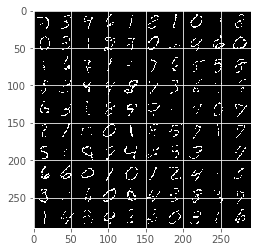

In [14]:
## set up some prems 
learning_rate = 0.001
cost = tf.reduce_mean(tf.reduce_mean(tf.squared_difference(X, Y), 1))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Some parameters for training
batch_size = 100
n_batch = mnist.train.num_examples//batch_size     ## get the integer number 
n_epochs = 5
examples = mnist.train.images[:100]
mean_img=mean_img.flatten()
# We'll store the reconstructions in a list
imgs = []
fig, ax = plt.subplots(1, 1)

for epoch_i in range(n_epochs):
    for i in range(n_batch):
        batch_X, _ = mnist.train.next_batch(batch_size)                        ## next_batch(n) returns X and Y 
        sess.run(optimizer, feed_dict={X: batch_X - mean_img})                 ## 
    recon = sess.run(Y, feed_dict={X: examples - mean_img})                    ## So what does this mean ???????
    recon = np.clip((recon + mean_img).reshape((-1, 28, 28)), 0, 255)
    img_i = montage(recon).astype(np.uint8)
    imgs.append(img_i)
    ax.imshow(img_i, cmap='gray')
    fig.canvas.draw()
    print(epoch_i, sess.run(cost, feed_dict={X: batch_X - mean_img}))         ## the reason we use batch_X rather then the entire thin, is befause memory
#gif.build_gif(imgs, saveto='ae.gif', cmap='gray')                            ## need to install ffmpeg 

#### The whole idea of encoding a picture is to compress all information of a image to its inner most layer while keep as much information as possible. 

- Denoising Autoencoder ,  and Variational Autoencoders are also very popular techniques used in auto encoding, please refer to this notebook for details https://github.com/pkmital/CADL/blob/master/session-3/lecture-3.ipynb